In [1]:
# 0 ─── Imports ────────────────────────────────────────────────────────────────
import torch, math, numpy as np, matplotlib.pyplot as plt
from torch.optim import Adam
from pathlib import Path
from tqdm.auto import tqdm

from four_head_2D import FourierHead2D             

In [2]:
# 1 ─── Helper functions ──────────────────────────────────────────────────────
import torch, math

MILES_PER_DEG_LAT = 69.0            # ≈ great-circle miles per degree latitude

# ---- quick utility ---------------------------------------------------------
def _to_tensor(x, device=None, dtype=torch.float32):
    """
    Accept scalars / NumPy arrays / tensors and return a torch.Tensor
    on the requested device & dtype.  Keeps gradients if `x` was already
    a tensor with requires_grad=True.
    """
    if isinstance(x, torch.Tensor):
        return x.to(device=device)
    return torch.as_tensor(x, dtype=dtype, device=device)

# ---- basic Earth geometry --------------------------------------------------
def miles_per_deg_lon(lat):
    """
    Miles per one degree of *longitude* at latitude `lat` (degrees).

    • Input can be float, ndarray, or Tensor.  
    • Output is a Tensor on the same device as `lat`.
    """
    lat_t = _to_tensor(lat)
    return MILES_PER_DEG_LAT * torch.cos(torch.deg2rad(lat_t))

# ---- global mapping  (deg² ➜ unit²) ----------------------------------------
def world_to_uv(lat, lon):
    """
    (lat, lon) in degrees  →  (u, v) in [-1,1]².
    """
    lat_t = _to_tensor(lat)
    lon_t = _to_tensor(lon, device=lat_t.device)
    return torch.stack([lon_t / 180.0, lat_t / 90.0], dim=-1)

# ---- local square mapping  (mile-box ➜ unit²) ------------------------------
def local_to_uv(last_latlon, query_latlon, *, half_side_mi: float = 50.0):
    """
    Map a 2·half_side_mi mile square centred on `last_latlon` into [-1,1]².

    Inputs
    ------
    last_latlon  (..., 2) Tensor : centre  (lat, lon)  in degrees
    query_latlon (..., 2) Tensor : points   (lat, lon)  in degrees

    Returns
    -------
    uv        (..., 2) Tensor  : unit-square coordinates
    log_detJ  (...)   Tensor   : log |∂(lat,lon)/∂(u,v)|  (for pdf change-of-vars)
    """
    lat0 = last_latlon[..., 0]

    # physical half-side → angular half-side
    dlat = half_side_mi / MILES_PER_DEG_LAT                 # scalar float
    dlon = half_side_mi / miles_per_deg_lon(lat0)           # tensor

    uv = torch.stack([
        (query_latlon[..., 1] - last_latlon[..., 1]) / dlon,    # u (east–west)
        (query_latlon[..., 0] - last_latlon[..., 0]) / dlat     # v (north–south)
    ], dim=-1)

    # Jacobian determinant is constant over affine map:
    # |det J| = 1 / (dlat * dlon)
    dlat_t = _to_tensor(dlat, device=lat0.device)
    log_detJ = -(torch.log(dlat_t) + torch.log(dlon))           # (...,)

    # Make it broadcastable to uv[...,0] when needed
    return uv, log_detJ.expand(uv.shape[:-1])

# ---- constant for world transform ------------------------------------------
LOG_J_WORLD = -math.log(180.0) - math.log(90.0)    # scalar float
# (If you ever need it on GPU, wrap via `_to_tensor(LOG_J_WORLD, device)`.)

In [3]:
# 2 ─── Tiny realistic AIS snippet (6 posits, 10-min step) ─────────────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

lats = torch.tensor([32.75, 32.77, 32.80, 32.82, 32.85, 32.87], device=device)
lons = torch.tensor([-79.90,-79.88,-79.85,-79.83,-79.80,-79.78], device=device)
track = torch.stack([lats, lons], -1)                # (6,2) deg

last_fix   = track[-2]                               # position-5
target_fix = track[-1]                               # position-6   ← only one target here

# Dummy context features: [speed_kn, heading_deg] + last_latlon
ctx = torch.tensor([[12.0, 85.0, *last_fix.cpu().tolist()]], device=device)   # (1,4)


In [4]:
# 3 ─── Check Jacobian sanity --------------------------------------------------
half_side_mi = 50.0

# Map the *single* target point into the local unit square
uv, logJ = local_to_uv(last_fix.unsqueeze(0),              # centre
                       target_fix.unsqueeze(0),            # query
                       half_side_mi=half_side_mi)

print(f"u,v  = {uv.cpu().numpy()}")          # should be near (0,0) for the immediate next fix
print(f"logJ = {logJ.item():.4f}")

# Area of the square in mi² recovered from the Jacobian:
area_ratio = (2*half_side_mi)**2 * torch.exp(logJ)   # ≈ 1.0e4 mi² × |detJ|
print(f"physical area / unit area = {area_ratio.item():.2f} mi²")

# -- sanity probability-mass check for a *uniform* density f_uv = 1/4 -----------
uniform_density = 0.25        # constant over [-1,1]², integrates to 1 on the unit square
mass = uniform_density * torch.exp(logJ) * (2*half_side_mi/MILES_PER_DEG_LAT) \
       * (2*half_side_mi / miles_per_deg_lon(last_fix[0]))    # integrate in deg² then map to mi²

print(f"uniform density mass = {mass.item():.3f}  (should be ≈ 1.0)")


u,v  = [[0.02319153 0.02760063]]
logJ = 0.4699
physical area / unit area = 15998.74 mi²
uniform density mass = 1.000  (should be ≈ 1.0)


In [5]:
# 3 ─── Build training targets and log-Jacobians ───────────────────────────────
t_world       = world_to_uv(target_fix[0], target_fix[1]).unsqueeze(0)
logJ_world    = torch.full((1,), LOG_J_WORLD, device=device)

t_local, logJ_local = local_to_uv(last_fix, target_fix.unsqueeze(0))  # (1,2), (1,)

# Sanity-check: make sure t_local is in (-1…1)
assert (t_local.abs() < 1.0 + 1e-3).all()


In [6]:
# 4 ─── Instantiate and train both heads (m = 20) ────────────────────────────
f_world = FourierHead2D(dim_input=4, num_frequencies=20).to(device)
f_local = FourierHead2D(dim_input=4, num_frequencies=20).to(device)

opt_w   = Adam(f_world.parameters(), lr=1e-2)   # lower LR → stabler fit
opt_l   = Adam(f_local.parameters(),  lr=1e-2)

epochs = 250
loss_w, loss_l = [], []

for ep in tqdm(range(epochs), desc="training"):
    # ---------- WORLD head --------------------------------------------------
    opt_w.zero_grad(set_to_none=True)
    pdf_w = f_world(ctx, t_world) * torch.exp(logJ_world)       # (1,)
    loss_w_val = -torch.log(pdf_w.clamp_min(1e-10)).mean()
    loss_w_val.backward()
    opt_w.step()
    loss_w.append(loss_w_val.item())

    # ---------- LOCAL head --------------------------------------------------
    opt_l.zero_grad(set_to_none=True)
    pdf_l = f_local(ctx, t_local) * torch.exp(logJ_local)       # (1,)
    loss_l_val = -torch.log(pdf_l.clamp_min(1e-10)).mean()
    loss_l_val.backward()
    opt_l.step()
    loss_l.append(loss_l_val.item())


training:   0%|          | 0/250 [00:00<?, ?it/s]

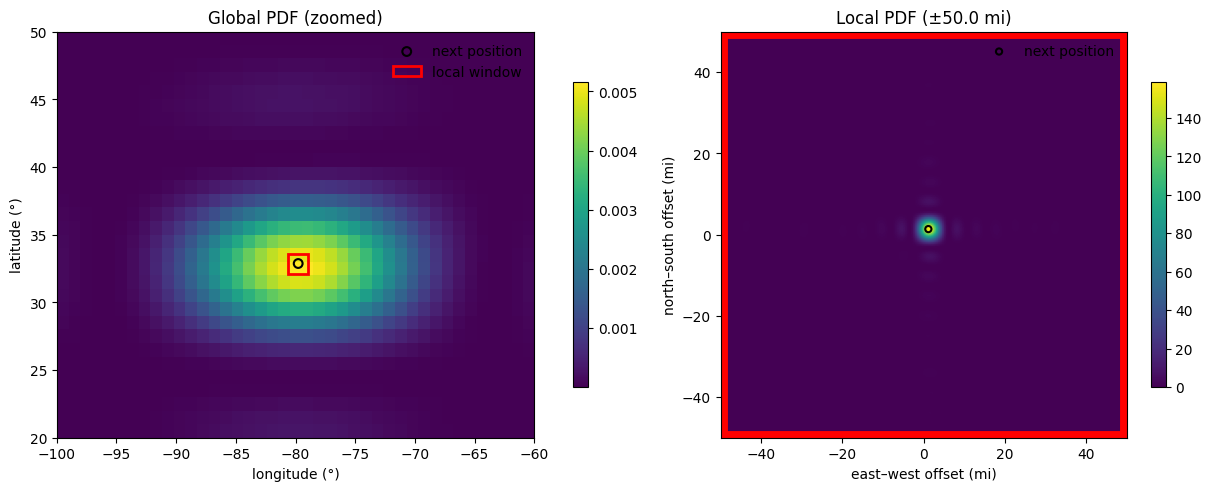

In [7]:
# 8 ─── Zoomed global PDF + local 100×100-mi PDF, with matching red boxes ────
import math, matplotlib.pyplot as plt
plt.close('all')

half_side_mi = 50.0                     # local window half-width/height


# 1) Evaluate both PDFs
with torch.no_grad():
    # GLOBAL 1° grid
    lon_g, lat_g = torch.meshgrid(
        torch.linspace(-180, 180, 361, device=device),
        torch.linspace( -90,  90, 180, device=device),
        indexing='xy'
    )
    ctx_glb = ctx.expand(lon_g.numel(), -1)
    pdf_g = (
        f_world(ctx_glb, world_to_uv(lat_g, lon_g).view(-1, 2)) *
        torch.exp(torch.tensor(LOG_J_WORLD, device=device))
    ).view(lat_g.shape).cpu()

    # LOCAL fine grid
    g_res  = 201
    lin    = torch.linspace(-1, 1, g_res, device=device)
    u, v   = torch.meshgrid(lin, lin, indexing='xy')
    uv_loc = torch.stack([u, v], -1).view(-1, 2)
    ctx_loc = ctx.expand(uv_loc.size(0), -1)
    pdf_l = (
        f_local(ctx_loc, uv_loc) * torch.exp(logJ_local)        # broadcast
    ).view(g_res, g_res).cpu()


# 2) Coordinate helpers
# --- zoom bounds for global panel
lon_min, lon_max = -100, -60
lat_min, lat_max =   20,  50
lat_vals = lat_g[:, 0].cpu(); lon_vals = lon_g[0, :].cpu()
lat_mask = (lat_vals >= lat_min) & (lat_vals <= lat_max)
lon_mask = (lon_vals >= lon_min) & (lon_vals <= lon_max)
pdf_zoom = pdf_g[lat_mask][:, lon_mask]
extent_zoom = [lon_min, lon_max, lat_min, lat_max]

# --- red-box corners for ±50-mi window (deg)
dlat = half_side_mi / MILES_PER_DEG_LAT
dlon = half_side_mi / miles_per_deg_lon(last_fix[0]).cpu().item()
lon0, lat0 = last_fix[1].cpu().item(), last_fix[0].cpu().item()

# --- local panel extents (mi)
extent_local = [-half_side_mi, half_side_mi, -half_side_mi, half_side_mi]
dx = (target_fix[1] - last_fix[1]) * miles_per_deg_lon(last_fix[0]).cpu()
dy = (target_fix[0] - last_fix[0]) * MILES_PER_DEG_LAT


# 3) Plot
fig, (axG, axL) = plt.subplots(1, 2, figsize=(12, 4.8), constrained_layout=True)

# ── (a) Global zoomed panel ───────────────────────────────────────────────
imG = axG.imshow(
    pdf_zoom, extent=extent_zoom, origin='lower', aspect='auto'
)
axG.scatter(
    target_fix[1].cpu(), target_fix[0].cpu(),
    marker='o', s=40, facecolors='none', edgecolors='k', linewidths=1.5,
    label='next position'
)
# red local-window box
axG.add_patch(
    plt.Rectangle((lon0 - dlon, lat0 - dlat), 2*dlon, 2*dlat,
                  fill=False, edgecolor='red', linewidth=2,
                  label='local window')
)
axG.set_title('Global PDF (zoomed)')
axG.set_xlabel('longitude (°)'); axG.set_ylabel('latitude (°)')
fig.colorbar(imG, ax=axG, shrink=0.75)
axG.legend(frameon=False, loc='upper right')

# ── (b) Local panel ───────────────────────────────────────────────────────
imL = axL.imshow(
    pdf_l, extent=extent_local, origin='lower', aspect='equal'
)
# surround entire local image with a red outline to match the global box
axL.add_patch(
    plt.Rectangle((-half_side_mi, -half_side_mi),
                  2*half_side_mi, 2*half_side_mi,
                  fill=False, edgecolor='red', linewidth=10)
)
axL.scatter(
    dx.cpu(), dy.cpu(),
    marker='o', s=20, facecolors='none', edgecolors='k', linewidths=1.5,
    label='next position'
)

axL.set_title(f'Local PDF (±{half_side_mi} mi)')
axL.set_xlabel('east–west offset (mi)')
axL.set_ylabel('north–south offset (mi)')
fig.colorbar(imL, ax=axL, shrink=0.75)
axL.legend(frameon=False, loc='upper right')

plt.show()
